In [2]:
%load_ext autoreload
%autoreload 2

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dqalgo.nisq.eval import get_truth_table_tomography_for_Fanout
from dqalgo.nisq.utils import get_depolarizing_noise_model
from dqalgo.vis import vis_bar_fid_vs_input, vis_line_avg_fid_vs_n_trgts
from dqalgo.data_mgr import NISQFanoutDataMgr
from dqalgo.nisq.eval import eval_Baumer_Fanout


# Visualize fidelities v.s. n_trgts

{'0000': np.float64(0.9955957701296244), '0001': np.float64(0.993140536379419), '0010': np.float64(0.9941233575366791), '0011': np.float64(0.9938777433618282), '0100': np.float64(0.995840960570512), '0101': np.float64(0.993140536379419), '0110': np.float64(0.9948598362332254), '0111': np.float64(0.9948598362332254), '1000': np.float64(0.995840960570512), '1001': np.float64(0.9948598362332254), '1010': np.float64(0.9951052080056662), '1011': np.float64(0.9955957701296244), '1100': np.float64(0.9946144039274718), '1101': np.float64(0.995840960570512), '1110': np.float64(0.9933863328282708), '1111': np.float64(0.9953505192895616)}
{'000000': np.float64(0.9921567416492215), '000001': np.float64(0.9899396288410723), '000010': np.float64(0.993140536379419), '000011': np.float64(0.9901862198596787), '000100': np.float64(0.9916644782889019), '000101': np.float64(0.9909256247317454), '000110': np.float64(0.9919106405064924), '000111': np.float64(0.9904327494837799), '001000': np.float64(0.99092

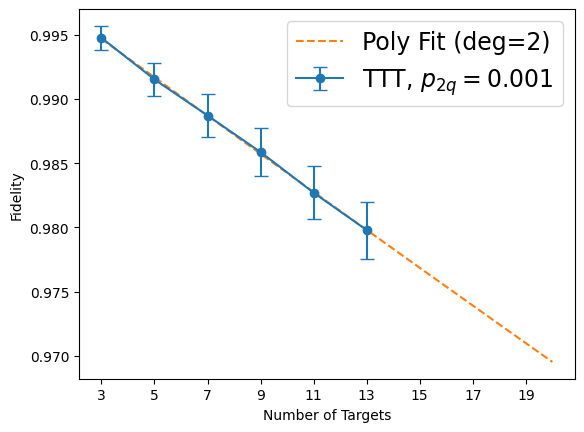

In [2]:
all_n_trgts_lst = [3, 5, 7, 9, 11, 13]
# simulation time for t=11: 643 s
p_2q_lst = [0.001]

dmgr = NISQFanoutDataMgr()

n_trgts_lst_lst = [[3,5,7],[9],[11],[13]]
input_to_fid_lst = []
for n_trgts_lst in n_trgts_lst_lst:
    tmp_input_to_fid_lst, _, _ = dmgr.load(n_trgts=n_trgts_lst, p_2q=p_2q_lst)
    input_to_fid_lst.extend(tmp_input_to_fid_lst)

for input_to_fid in input_to_fid_lst:
    print(input_to_fid)
assert isinstance(input_to_fid_lst, list)
assert isinstance(input_to_fid_lst[0], dict)

avg_fids = [np.mean(list(input_to_fid.values())) for input_to_fid in input_to_fid_lst]
avg_fids = np.array(avg_fids)
print(avg_fids)
p_2q_idx = 0

coeffs = np.polyfit(all_n_trgts_lst, avg_fids, deg=2)
print(coeffs)
fitted_fn = np.poly1d(coeffs)

# Generate smooth x values for plotting the curve
x_max = 20
x_fit = np.linspace(min(all_n_trgts_lst), x_max, 300)
y_fit = fitted_fn(x_fit)

fig, ax = plt.subplots()


params = {'legend.fontsize': 17,
            #   'figure.figsize': (8, 5),
              'axes.labelsize': 18,  # 'x-large',
              'axes.titlesize': 20,  # 'x-large',
              'xtick.labelsize': 18,
              'ytick.labelsize': 18,
              'pdf.fonttype': 42,
              'ps.fonttype': 42, }
plt.rcParams.update(params)

# ax.plot(n_trgts_lst, avg_fids, marker='o')
std_fids = [np.std(list(input_to_fid.values())) for input_to_fid in input_to_fid_lst]
ax.errorbar(all_n_trgts_lst, avg_fids, yerr=std_fids, fmt='-o', capsize=5, label=f"TTT, $p_{{2q}}={p_2q_lst[0]}$")
ax.plot(x_fit, y_fit, label=f'Poly Fit (deg=2)', linestyle='--')
ax.set_xticks(range(min(all_n_trgts_lst), x_max+1, 2))
ax.set_xlabel("Number of Targets")
ax.set_ylabel("Fidelity")
ax.legend()
# ax.set_title("Fidelity vs Number of Targets")
# vis_line_avg_fid_vs_n_trgts(ax, n_trgts_lst, list(avg_fids))
plt.show()

# Visualize one truth table tomography

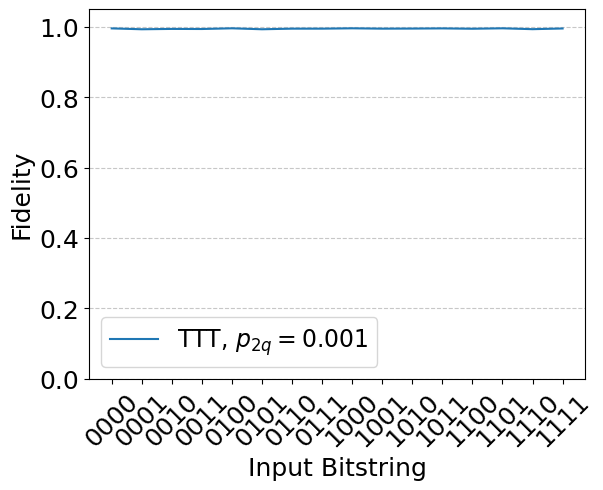

In [3]:
n_trgts = 3
p_2q = 0.001

input_to_fid = input_to_fid_lst[0]
fig, ax = plt.subplots()
# vis_bar_fid_vs_input(ax, input_to_fid)
x = list(input_to_fid.keys())
y = list(input_to_fid.values())
ax.plot(x, y, label=f"TTT, $p_{{2q}}={p_2q}$")
ax.set_xticks(x, x, rotation=45)
ax.set_xlabel("Input Bitstring")
ax.set_ylabel("Fidelity")
ax.set_ylim(0, 1.05)  # Set y-axis to go up to 1.05 for clarity
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()
# ax.set_title(f"TTT, $n_{{trgts}}={n_trgts}$, $p_{{2q}}={p_2q}$")
plt.show()


# eval Baumer Fanout using stim's Tableau

In [24]:
n_trgts_lst = [4, 6, 8]
p2s = [0.001, 0.003, 0.005]
n_shots = 100000

dmgr = NISQFanoutDataMgr()
data = dmgr.load(n_trgts=n_trgts_lst, p2=p2s, n_shots=n_shots)
error_counts_lst, _, _ = data
print(error_counts_lst)

columns = ["Noise", "\\# Trgts", "1st Error", "2nd Error", "3rd Error", "4th Error", "5th Error"]
rows = []
top_errors_lst = []
for error_counts, (n_trgts, p2) in zip(error_counts_lst, itertools.product(n_trgts_lst, p2s)):
    row = [p2, n_trgts]
    top_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    error_strs = [f"{error[1:]}: {count/n_shots:.2%}" for error, count in top_errors]
    row.extend(error_strs)
    rows.append(row)
df = pd.DataFrame(rows, columns=columns)
# df.to_csv("top_errors.csv", index=False)
filepath = dmgr.get_filepath(n_trgts=n_trgts_lst, p2=p2s, n_shots=n_shots)
df.to_csv(f"../../data/nisq/fanout/top_errors-n_trgts={n_trgts_lst},p2={p2s},n_shots={n_shots}.pkl", index=False)

[{'+_XXXX': 124, '+____X': 51, '+Z____': 350, '+ZXXXX': 17, '+Z__XX': 37, '+Z___Z': 16, '+_Z___': 8, '+___XX': 133, '+X____': 24, '+__Z__': 9, '+Z___X': 46, '+__ZXX': 3, '+Z_XXX': 31, '+ZX___': 5, '+Z__Y_': 12, '+Z_Z__': 8, '+XXXXX': 6, '+___YX': 8, '+Z___Y': 14, '+__XXX': 42, '+Z__Z_': 6, '+Z__X_': 4, '+Z_X__': 7, '+____Y': 16, '+YXXXX': 15, '+___Y_': 14, '+___X_': 5, '+_Y___': 9, '+Y____': 17, '+Z_YXX': 19, '+__X__': 8, '+____Z': 12, '+_ZXXX': 4, '+Z_Y__': 7, '+___Z_': 7, '+__Y__': 7, '+_YXXX': 12, '+__YXX': 8, '+X__XX': 1, '+Z__YX': 3, '+ZXXX_': 1, '+ZYXXX': 8, '+Z__ZX': 9, '+___ZX': 5, '+ZZ___': 7, '+Z_ZXX': 3, '+_X___': 4, '+ZY___': 4, '+ZZXXX': 2, '+ZXYXX': 1, '+ZX_XX': 1}, {'+Z____': 1015, '+Z___X': 140, '+_XXXX': 354, '+____Z': 49, '+___XX': 368, '+XXXXX': 53, '+Z__ZX': 32, '+Z__Z_': 18, '+Z_XXX': 102, '+____X': 152, '+_X___': 20, '+___X_': 21, '+__X__': 22, '+YXXXX': 29, '+__Z__': 25, '+___Y_': 24, '+ZX___': 28, '+__XXX': 118, '+_ZXXX': 21, '+Z__YX': 19, '+Z_X__': 20, '+Z__X_'

In [25]:
df

,Noise,\# Trgts,1st Error,2nd Error,3rd Error,4th Error,5th Error
0,0.001,4,Z____: 0.35%,___XX: 0.13%,_XXXX: 0.12%,____X: 0.05%,Z___X: 0.05%
1,0.003,4,Z____: 1.01%,___XX: 0.37%,_XXXX: 0.35%,____X: 0.15%,Z___X: 0.14%
2,0.005,4,Z____: 1.64%,___XX: 0.70%,_XXXX: 0.58%,____X: 0.22%,Z__XX: 0.21%
3,0.001,6,Z______: 0.54%,___XXXX: 0.14%,_XXXXXX: 0.14%,_____XX: 0.13%,Z____XX: 0.05%
4,0.003,6,Z______: 1.52%,_____XX: 0.41%,___XXXX: 0.40%,_XXXXXX: 0.35%,Z_____X: 0.14%
5,0.005,6,Z______: 2.46%,_____XX: 0.63%,___XXXX: 0.60%,_XXXXXX: 0.56%,Z_____X: 0.23%
6,0.001,8,Z________: 0.73%,_______XX: 0.15%,_____XXXX: 0.13%,___XXXXXX: 0.13%,_XXXXXXXX: 0.12%
7,0.003,8,Z________: 2.07%,___XXXXXX: 0.42%,_______XX: 0.41%,_____XXXX: 0.38%,_XXXXXXXX: 0.32%
8,0.005,8,Z________: 3.27%,_______XX: 0.68%,___XXXXXX: 0.61%,_____XXXX: 0.61%,_XXXXXXXX: 0.56%


In [26]:
latex_tabular = df.to_latex(
    index=False,                          # don’t print the DataFrame index
    caption="Top 5 Errors by Noise Level and Number of Targets",
    label="tab:fanout_errors",
    float_format="%.3f",
    column_format="llccccc",              # adjust: two left cols + 5 centered cols
    escape=True                          # if your error names contain LaTeX chars
)
print(latex_tabular)

\begin{table}
\caption{Top 5 Errors by Noise Level and Number of Targets}
\label{tab:fanout_errors}
\begin{tabular}{llccccc}
\toprule
Noise & \textbackslash \# Trgts & 1st Error & 2nd Error & 3rd Error & 4th Error & 5th Error \\
\midrule
0.001 & 4 & Z\_\_\_\_: 0.35\% & \_\_\_XX: 0.13\% & \_XXXX: 0.12\% & \_\_\_\_X: 0.05\% & Z\_\_\_X: 0.05\% \\
0.003 & 4 & Z\_\_\_\_: 1.01\% & \_\_\_XX: 0.37\% & \_XXXX: 0.35\% & \_\_\_\_X: 0.15\% & Z\_\_\_X: 0.14\% \\
0.005 & 4 & Z\_\_\_\_: 1.64\% & \_\_\_XX: 0.70\% & \_XXXX: 0.58\% & \_\_\_\_X: 0.22\% & Z\_\_XX: 0.21\% \\
0.001 & 6 & Z\_\_\_\_\_\_: 0.54\% & \_\_\_XXXX: 0.14\% & \_XXXXXX: 0.14\% & \_\_\_\_\_XX: 0.13\% & Z\_\_\_\_XX: 0.05\% \\
0.003 & 6 & Z\_\_\_\_\_\_: 1.52\% & \_\_\_\_\_XX: 0.41\% & \_\_\_XXXX: 0.40\% & \_XXXXXX: 0.35\% & Z\_\_\_\_\_X: 0.14\% \\
0.005 & 6 & Z\_\_\_\_\_\_: 2.46\% & \_\_\_\_\_XX: 0.63\% & \_\_\_XXXX: 0.60\% & \_XXXXXX: 0.56\% & Z\_\_\_\_\_X: 0.23\% \\
0.001 & 8 & Z\_\_\_\_\_\_\_\_: 0.73\% & \_\_\_\_\_\_\_XX: 0.15\% & \_\_

# Eval Teleportation circuit using Stim.TableauSimulator

In [3]:
from dqalgo.data_mgr import NISQTeleportDataMgr

n_trgts_lst = [4, 6, 8]
p2s = [0.001, 0.003, 0.005]
n_shots = 100000

dmgr = NISQTeleportDataMgr()
data = dmgr.load(n_trgts=n_trgts_lst, p2=p2s, n_shots=n_shots)
error_counts_lst, _, _ = data
print(error_counts_lst)

columns = ["Noise", "\\# Trgts", "1st Error", "2nd Error", "3rd Error", "4th Error", "5th Error"]
rows = []
top_errors_lst = []
for error_counts, (n_trgts, p2) in zip(error_counts_lst, itertools.product(n_trgts_lst, p2s)):
    row = [p2, n_trgts]
    top_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    error_strs = [f"{error[1:]}: {count/n_shots:.2%}" for error, count in top_errors]
    row.extend(error_strs)
    rows.append(row)

df = pd.DataFrame(rows, columns=columns)
print(df)

[{'+__X_': 58, '+___X': 75, '+X___': 54, '+_X__': 67, '+XX__': 1}, {'+___X': 193, '+_X__': 173, '+__X_': 192, '+X___': 183, '+_X_X': 2, '+XX__': 1, '+__XX': 1}, {'+X___': 271, '+___X': 297, '+__X_': 260, '+_XX_': 2, '+_X__': 266, '+_X_X': 2, '+__XX': 2, '+X_X_': 1, '+XX__': 2}, {'+____X_': 65, '+_____X': 84, '+X_____': 65, '+___X__': 55, '+_X____': 65, '+__X___': 67, '+XX____': 1}, {'+_____X': 177, '+X_____': 180, '+__X___': 173, '+_X____': 178, '+____X_': 188, '+___X__': 171, '+_XX___': 1}, {'+___X__': 275, '+X_____': 266, '+__X___': 296, '+____X_': 330, '+_____X': 311, '+_X____': 316, '+X__X__': 3, '+X____X': 2, '+_X_X__': 2, '+X_X___': 2, '+XX____': 1, '+_XX___': 1, '+X___X_': 1, '+____XX': 1}, {'+____X___': 57, '+_X______': 44, '+X_______': 47, '+______X_': 59, '+_____X__': 62, '+_______X': 56, '+___X____': 56, '+__X_____': 57}, {'+___X____': 198, '+X_______': 177, '+__X_____': 175, '+_X______': 159, '+____X___': 175, '+_____X__': 190, '+_______X': 162, '+______X_': 169, '+__X____X

# Eval telegate

In [4]:
from dqalgo.data_mgr import NISQTelegateDataMgr

n_trgts_lst = [4, 6, 8]
p2s = [0.001, 0.003, 0.005]
n_shots = 100000

dmgr = NISQTelegateDataMgr()
data = dmgr.load(n_trgts=n_trgts_lst, p2=p2s, n_shots=n_shots)
error_counts_lst, _, _ = data
print(error_counts_lst)

columns = ["Noise", "\\# Trgts", "1st Error", "2nd Error", "3rd Error", "4th Error", "5th Error"]
rows = []
top_errors_lst = []
for error_counts, (n_trgts, p2) in zip(error_counts_lst, itertools.product(n_trgts_lst, p2s)):
    row = [p2, n_trgts]
    top_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:5]
    error_strs = [f"{error[1:]}: {count/n_shots:.2%}" for error, count in top_errors]
    row.extend(error_strs)
    rows.append(row)

df = pd.DataFrame(rows, columns=columns)
print(df)

[{'+_X__': 145, '+X___': 163, '+___X': 170, '+__Z_': 29, '+__X_': 164, '+Y___': 23, '+__Y_': 24, '+_Z__': 23, '+___Y': 23, '+_Y__': 24, '+___Z': 25, '+Z___': 24, '+Y_X_': 1, '+XX__': 1, '+Y__X': 1}, {'+X___': 514, '+_Y__': 79, '+___Z': 89, '+ZY__': 1, '+_X__': 513, '+___X': 524, '+__Y_': 74, '+__X_': 501, '+__Z_': 80, '+Y___': 90, '+Z___': 79, '+_Z__': 84, '+_X_X': 2, '+Z_X_': 2, '+___Y': 75, '+X_X_': 3, '+_XX_': 6, '+_XZ_': 2, '+Y__X': 1, '+XX__': 4, '+X_Y_': 2, '+XY__': 3, '+_Y_X': 1, '+YX__': 1, '+X__X': 1, '+__XZ': 1, '+_Z_X': 1, '+X__Y': 1, '+__YZ': 1, '+XZ__': 1, '+__XX': 1, '+X__Z': 1, '+_XY_': 1}, {'+_X__': 871, '+X___': 880, '+___X': 917, '+__X_': 885, '+___Z': 128, '+_Y__': 129, '+__Y_': 161, '+___Y': 159, '+__Z_': 157, '+Y___': 138, '+Z___': 136, '+_Z__': 127, '+__XX': 8, '+X__X': 7, '+_ZX_': 3, '+_X_X': 8, '+__XY': 3, '+Y__Y': 1, '+__ZZ': 1, '+Y_X_': 3, '+X_X_': 12, '+Z__X': 1, '+_XX_': 6, '+YX__': 3, '+__YY': 1, '+ZX__': 1, '+_XY_': 1, '+_XZ_': 1, '+_X_Z': 1, '+X_Y_': 1, '